# Logistic Regression

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump
import seaborn as sns
import statsmodels.api as sm

In [2]:
import sys
sys.path.append('F:\\Users\\Manuel García Plaza\\Desktop\\TFG\\')

In [3]:
from notebooks.utils.classification_metrics import classification

We are going to proceed as we did in the breast cancer notebook

In [4]:
train =  pd.read_parquet('../../../data/model_input/train_sets/car_insurance.parquet')
validation =  pd.read_parquet('../../../data/model_input/validation_sets/car_insurance.parquet')

In [5]:
y_train = train.OUTCOME
X_train = train.drop(columns=['OUTCOME'])

In [6]:
y_validation = validation.OUTCOME
X_validation = validation.drop(columns=['OUTCOME'])

We are going to scale for avoiding convergence problems

In [7]:
scaler = StandardScaler().fit(X_train, y_train)

In [8]:
X_train_scaled = scaler.transform(X_train)
X_validation_scaled = scaler.transform(X_validation)

In [9]:
lr = LogisticRegression(penalty=None)
lr_l2 = LogisticRegression()
lr_l1 = LogisticRegression(penalty='l1', solver='liblinear')
lr_en1 = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.25)
lr_en2 = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5 )
lr_en3 = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.75)

In [10]:
models_list = [lr, lr_l2, lr_l1, lr_en1, lr_en2 , lr_en3]
names_list = ['LR', 'LR_l2', 'LR_l1', 'LR_en_0.25', 'LR_en_0.5', 'LR_en_0.75']

In [11]:
metrics = classification(models_list, names_list, '../../../data/metrics/car_insurance/logistic_regression.csv', X_train_scaled, y_train, X_validation_scaled, y_validation)
metrics

,Run_Time,Train_AUC,Validation_AUC,delta%
LR,0.047869,0.905282,0.901046,-0.467994
LR_l2,0.026928,0.905271,0.901040,-0.467462
LR_l1,0.283261,0.905258,0.900978,-0.472751
LR_en_0.25,0.372413,0.905268,0.901064,-0.464359
LR_en_0.5,0.168928,0.905266,0.901044,-0.466459
LR_en_0.75,0.128682,0.905263,0.901019,-0.468843


Every model performs well, they got about the same metrics. We are going to select the l2 model because it has the lowest run time.

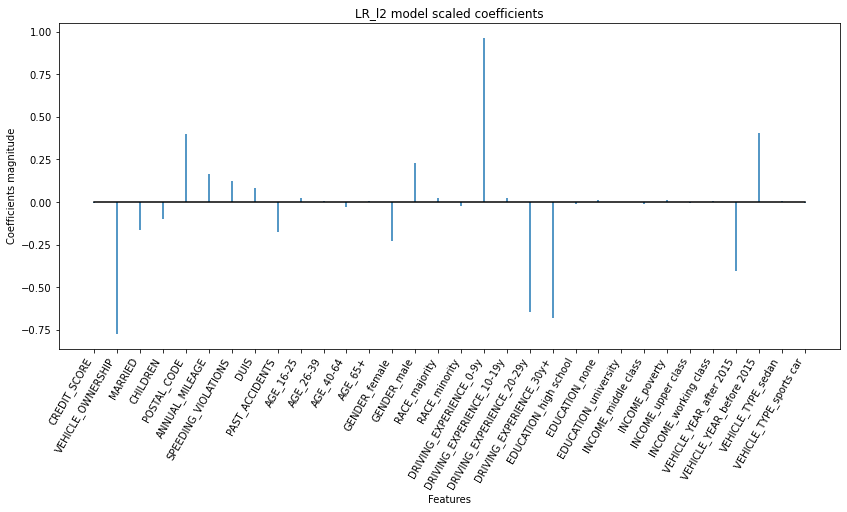

In [12]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.stem(X_train.columns, lr_l2.coef_.ravel(), markerfmt=' ', basefmt='k-')
plt.xticks(rotation=60, ha='right')
ax.set_xlabel('Features')
ax.set_ylabel('Coefficients magnitude')
ax.set_title('LR_l2 model scaled coefficients');

In [13]:
test =  pd.read_parquet('../../../data/model_input/test_sets/car_insurance.parquet')

In [14]:
y_test = test.OUTCOME
X_test = test.drop(columns=['OUTCOME'])

In [15]:
retrain = pd.concat([train, validation])

In [16]:
y_retrain = retrain.OUTCOME
X_retrain = retrain.drop(columns=['OUTCOME'])

In [17]:
scaler_retrain = StandardScaler().fit(X_retrain, y_retrain)

In [18]:
X_retrain_scaled = scaler_retrain.transform(X_retrain)
X_test_scaled = scaler_retrain.transform(X_test)

In [19]:
model = LogisticRegression().fit(X_retrain_scaled, y_retrain)

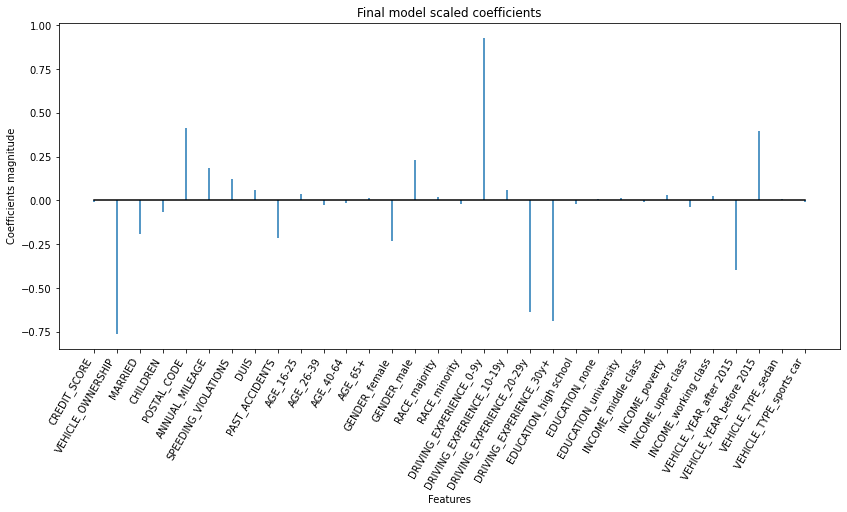

In [20]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.stem(X_retrain.columns, model.coef_.ravel(), markerfmt=' ', basefmt='k-')
plt.xticks(rotation=60, ha='right')
ax.set_xlabel('Features')
ax.set_ylabel('Coefficients magnitude')
ax.set_title('Final model scaled coefficients');

In [21]:
test_pred = model.predict_proba(X_test_scaled)[:, 1]
auc = roc_auc_score(y_test, test_pred)
print('Test AUC:', round(auc, 4))

Test AUC: 0.909


We save the final model:

In [22]:
dump(model, 'best_logistic_regression.joblib')

['best_logistic_regression.joblib']

And also save the final performance for the reporting:

In [23]:
with open('../../../data/metrics/car_insurance/final_AUC.txt', 'a') as f:
    f.write('\nLR, '+ str(auc))